In [1]:
!pip install geemap
!pip install rasterio
import geemap
import ee
import time
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from PIL import Image
from google.colab import drive

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 41.1 MB/s eta 0:00:00


In [2]:

# Autentication and Initialization
ee.Authenticate()
ee.Initialize(project="alessiodeluca")

drive.mount('/content/drive/', force_remount=True)
%cd /content/drive/My Drive/Environment/RemoteSensingProject/

%ls

Mounted at /content/drive/
/content/drive/My Drive/Environment/RemoteSensingProject
gee/  images/  Notebooks/


In [4]:
# Definition of the Area of Interest (AOI) in Croatia
geometry = ee.Geometry.Point([16.563798, 43.496451])
roi = geometry.buffer(10000)

# Function to select the image based on the date
def get_image_by_date(collection, date):
    return collection.filterDate(date, date).first()

# Sentinel-2 image collection for July and August 2017
collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
                .filterBounds(geometry) \
                .filterDate('2017-07-06', '2017-08-10')

# Extract and print the dates of the images in the collection
image_dates = collection.aggregate_array('system:time_start').getInfo()

# Convert the dates from timestamp to readable format
image_dates = [ee.Date(date).format('YYYY-MM-dd').getInfo() for date in image_dates]

# Print the dates
for i, date in enumerate(image_dates):
    print(f"Image {i + 1}: {date}")


Image 1: 2017-07-07
Image 2: 2017-07-17
Image 3: 2017-07-27
Image 4: 2017-08-06


In [5]:

print(collection.size().getInfo())

4


In [6]:
imageList = collection.toList(collection.size())

pre_fire_image = imageList.get(0)
pre_fire_image = ee.Image(pre_fire_image)

during_fire_image = imageList.get(1)
during_fire_image = ee.Image(during_fire_image)

post_fire_image = imageList.get(3)
post_fire_image = ee.Image(post_fire_image)

In [7]:
# Select only bands B4 (Red) and B8 (NIR)
pre_fire_image = pre_fire_image.select(['B4', 'B8'])
during_fire_image = during_fire_image.select(['B4', 'B8'])
post_fire_image = post_fire_image.select(['B4', 'B8'])

In [8]:
# Function to export the image to Google Drive
def export_image_to_drive(image, description, folder, scale, region):
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=description,
        folder=folder,
        scale=scale,
        region=region,
        maxPixels=1e13  # Allows exporting large images
    )
    task.start()

# Export images to Google Drive
export_image_to_drive(pre_fire_image, 'PreFireImageNDVI', 'gee', 10, roi)
export_image_to_drive(during_fire_image, 'DuringFireImageNDVI', 'gee', 10, roi)
export_image_to_drive(post_fire_image, 'PostFireImageNDVI', 'gee', 10, roi)

print("Image export started.")


Image export started.


In [9]:


# Function to monitor the task status
def monitor_task(task):
    while task.active():
        print(f'Task {task.status().get("description")} is {task.status().get("state")}')
        time.sleep(10)  # Wait 10 seconds before checking again
    print(f'Task {task.status().get("description")} completed with status: {task.status().get("state")}')

# Modify the export_image_to_drive function to return the task
def export_image_to_drive(image, description, folder, scale, region):
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=description,
        folder=folder,
        scale=scale,
        region=region,
        maxPixels=1e13
    )
    task.start()
    return task  # Return the task for monitoring

# Execute the export and monitor the task status
pre_fire_task = export_image_to_drive(pre_fire_image, 'PreFireImageNDVI', 'gee', 10, roi)
monitor_task(pre_fire_task)

during_fire_task = export_image_to_drive(during_fire_image, 'DuringFireImageNDVI', 'gee', 10, roi)
monitor_task(during_fire_task)

post_fire_task = export_image_to_drive(post_fire_image, 'PostFireImageNDVI', 'gee', 10, roi)
monitor_task(post_fire_task)


Task PreFireImageNDVI is READY
Task PreFireImageNDVI is READY
Task PreFireImageNDVI is READY
Task PreFireImageNDVI is READY
Task PreFireImageNDVI is READY
Task PreFireImageNDVI is READY
Task PreFireImageNDVI is READY
Task PreFireImageNDVI is READY
Task PreFireImageNDVI is READY
Task PreFireImageNDVI is RUNNING
Task PreFireImageNDVI is RUNNING
Task PreFireImageNDVI is RUNNING
Task PreFireImageNDVI is RUNNING
Task PreFireImageNDVI is RUNNING
Task PreFireImageNDVI is RUNNING
Task PreFireImageNDVI is RUNNING
Task PreFireImageNDVI is RUNNING
Task PreFireImageNDVI completed with status: COMPLETED
Task DuringFireImageNDVI is READY
Task DuringFireImageNDVI is RUNNING
Task DuringFireImageNDVI is RUNNING
Task DuringFireImageNDVI is RUNNING
Task DuringFireImageNDVI is RUNNING
Task DuringFireImageNDVI is RUNNING
Task DuringFireImageNDVI is RUNNING
Task DuringFireImageNDVI is RUNNING
Task DuringFireImageNDVI completed with status: COMPLETED
Task PostFireImageNDVI is READY
Task PostFireImageNDVI is 

In [10]:
# Open the .tif image
with rasterio.open('/content/drive/My Drive/Environment/RemoteSensingProject/gee/PreFireImageNDVI.tif') as src:
    print(f"The image has {src.count} band(s)")


The image has 2 band(s)


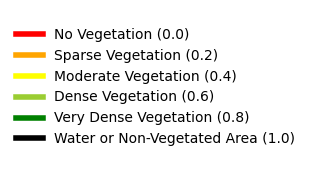

Processing PreFireImage image...


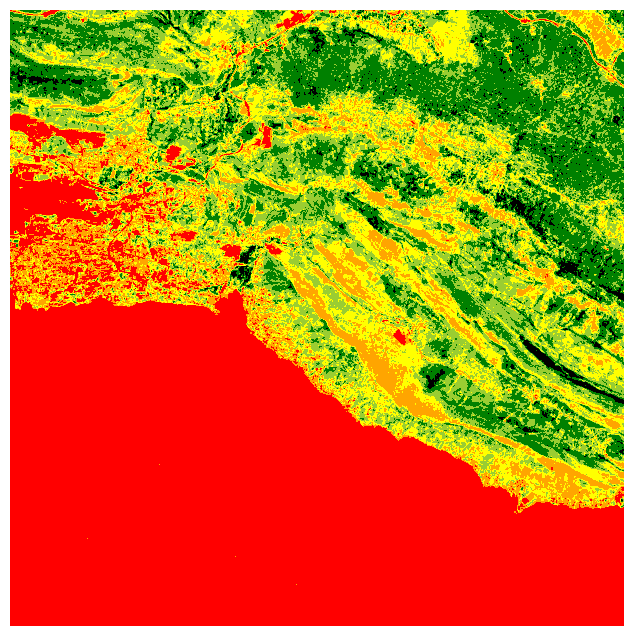

Processing DuringFireImage image...


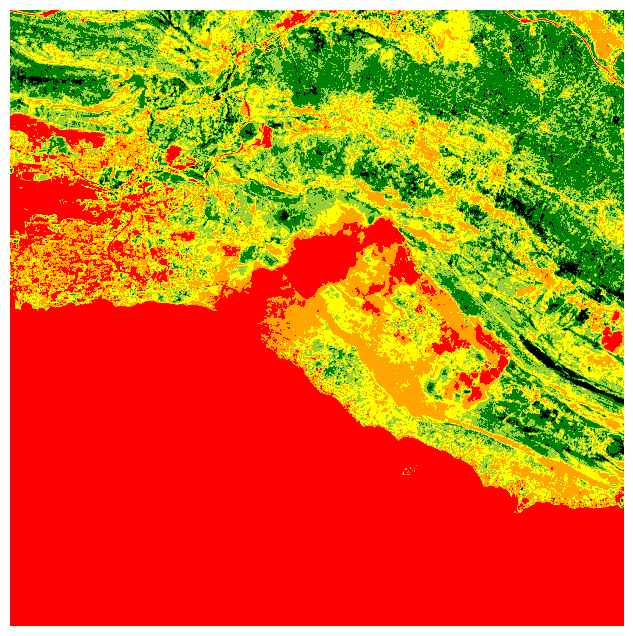

Processing PostFireImage image...


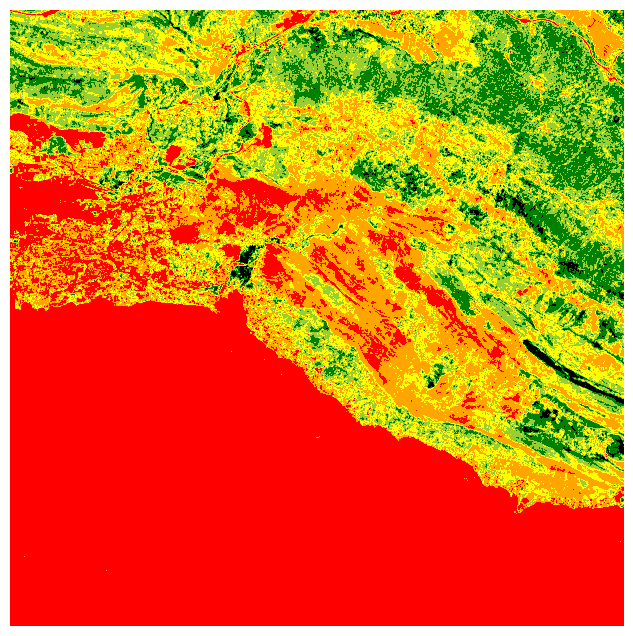

In [11]:


# Define file paths
image_paths = {
    'PreFireImage': '/content/drive/My Drive/Environment/RemoteSensingProject/gee/PreFireImageNDVI.tif',
    'DuringFireImage': '/content/drive/My Drive/Environment/RemoteSensingProject/gee/DuringFireImageNDVI.tif',
    'PostFireImage': '/content/drive/My Drive/Environment/RemoteSensingProject/gee/PostFireImageNDVI.tif'
}

# Define color map
cmap = ListedColormap(['red', 'orange', 'yellow', 'yellowgreen', 'green', 'black'])

# Configure min and max values for display
display_min = 0
display_max = 1

# Function to calculate and save NDVI
def process_image(image_path, output_image_path):
    with rasterio.open(image_path) as src:
        # Read bands B4 (Red) and B8 (NIR)
        red = src.read(1)  # Band B4
        nir = src.read(2)  # Band B8

    # Calculate NDVI: (NIR - RED) / (NIR + RED)
    ndvi = (nir.astype(float) - red.astype(float)) / (nir + red)

    # Handle NaN or infinite values
    ndvi = np.nan_to_num(ndvi, nan=0.0, posinf=1.0, neginf=-1.0)

    # Create figure and axis for the NDVI image
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(ndvi, cmap=cmap, vmin=display_min, vmax=display_max)
    ax.axis('off')  # Remove axes

    # Save the NDVI image
    plt.savefig(output_image_path, bbox_inches='tight', pad_inches=0, dpi=300)

    # Display the NDVI image
    plt.show()

# Create and save legend
def create_legend(output_legend_path):
    legend_labels = [
        (0.0, 'No Vegetation'),
        (0.2, 'Sparse Vegetation'),
        (0.4, 'Moderate Vegetation'),
        (0.6, 'Dense Vegetation'),
        (0.8, 'Very Dense Vegetation'),
        (1.0, 'Water or Non-Vegetated Area')
    ]

    legend_elements = [Line2D([0], [0], color=cmap(i / len(legend_labels)), lw=4, label=f'{label} ({value})') for i, (value, label) in enumerate(legend_labels)]

    # Create figure and axis for the legend
    fig_leg, ax_leg = plt.subplots(figsize=(2, 2))
    ax_leg.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.5, 0.5), ncol=1, frameon=False)
    ax_leg.axis('off')  # Remove axes

    # Save the legend as an image
    plt.savefig(output_legend_path, bbox_inches='tight', pad_inches=0, dpi=300)

    # Display the legend
    plt.show()

# Paths to save images
output_image_paths = {
    'PreFireImage': '/content/drive/My Drive/Environment/RemoteSensingProject/images/PreFireImage_NDVI.png',
    'DuringFireImage': '/content/drive/My Drive/Environment/RemoteSensingProject/images/DuringFireImage_NDVI.png',
    'PostFireImage': '/content/drive/My Drive/Environment/RemoteSensingProject/images/PostFireImage_NDVI.png'
}

# Path to save the legend
output_legend_path = '/content/drive/My Drive/Environment/RemoteSensingProject/images/NDVI_Legend.png'

# Create and save the legend
create_legend(output_legend_path)

# Process images
for label, path in image_paths.items():
    print(f"Processing {label} image...")
    process_image(path, output_image_paths[label])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


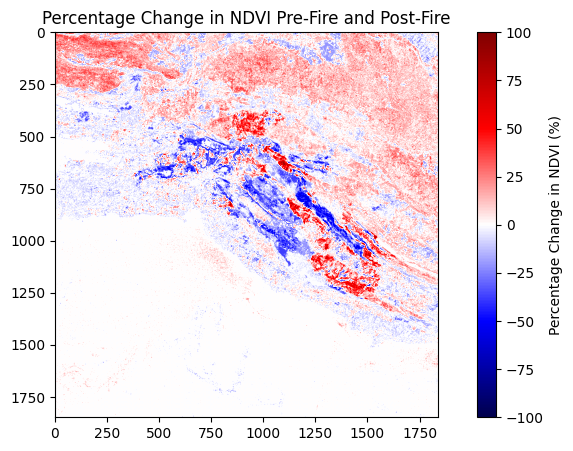

Image saved at: /content/drive/My Drive/Environment/RemoteSensingProject/images/NDVI_Percentage_Change.png


In [12]:


# Mount Google Drive
drive.mount('/content/drive')

# Paths to the saved NDVI images in PNG
pre_fire_image_path = '/content/drive/My Drive/Environment/RemoteSensingProject/images/PreFireImage_NDVI.png'
post_fire_image_path = '/content/drive/My Drive/Environment/RemoteSensingProject/images/PostFireImage_NDVI.png'

# Load the images
pre_fire_image = Image.open(pre_fire_image_path).convert('L')  # Convert to grayscale
post_fire_image = Image.open(post_fire_image_path).convert('L')

# Convert images to numpy arrays
pre_fire_array = np.array(pre_fire_image, dtype=float)
post_fire_array = np.array(post_fire_image, dtype=float)

# Calculate the difference between the images
difference_array = post_fire_array - pre_fire_array

# Convert the difference to a percentage scale (0-255)
percentage_difference_array = (difference_array / 255.0) * 100

# Create the figure and save it locally
plt.figure(figsize=(10, 5))
plt.title("Percentage Change in NDVI Pre-Fire and Post-Fire")
plt.imshow(percentage_difference_array, cmap='seismic', vmin=-100, vmax=100)  # Seismic colormap to highlight changes
plt.colorbar(label="Percentage Change in NDVI (%)")

# Save the image to Drive
image_save_path = '/content/drive/My Drive/Environment/RemoteSensingProject/images/NDVI_Percentage_Change.png'
plt.savefig(image_save_path)
plt.show()

print(f"Image saved at: {image_save_path}")
